In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from astropy import coordinates as ac
import copy
import torch

In [2]:
def plot_3d_points(coordinates):

    colors = 'blue'

    xs = coordinates[:, 0]
    ys = coordinates[:, 1]
    zs = coordinates[:, 2]

    fig = plt.figure(figsize=(20, 14))
    ax = plt.axes(projection="3d")
    ax.scatter3D(xs, ys, zs, c=colors)
    plt.show()
    return

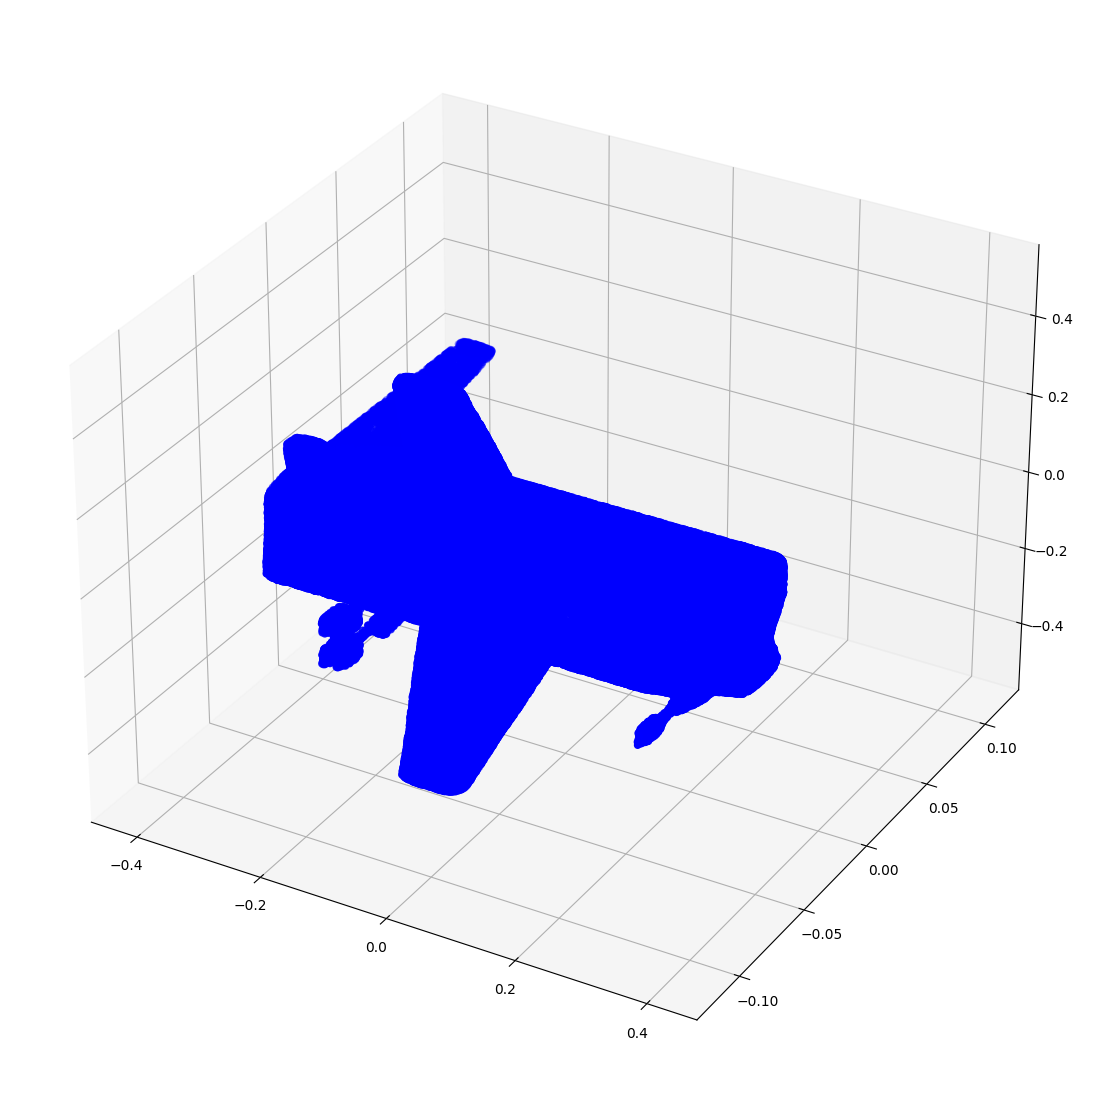

In [3]:
path = "/Users/liyang/demo_shapenet/ffef991d85e3136a9a6e43b878d5b335/pointcloud.npz"
data = np.load(path)
spn_points =  data['points']
plot_3d_points(spn_points)

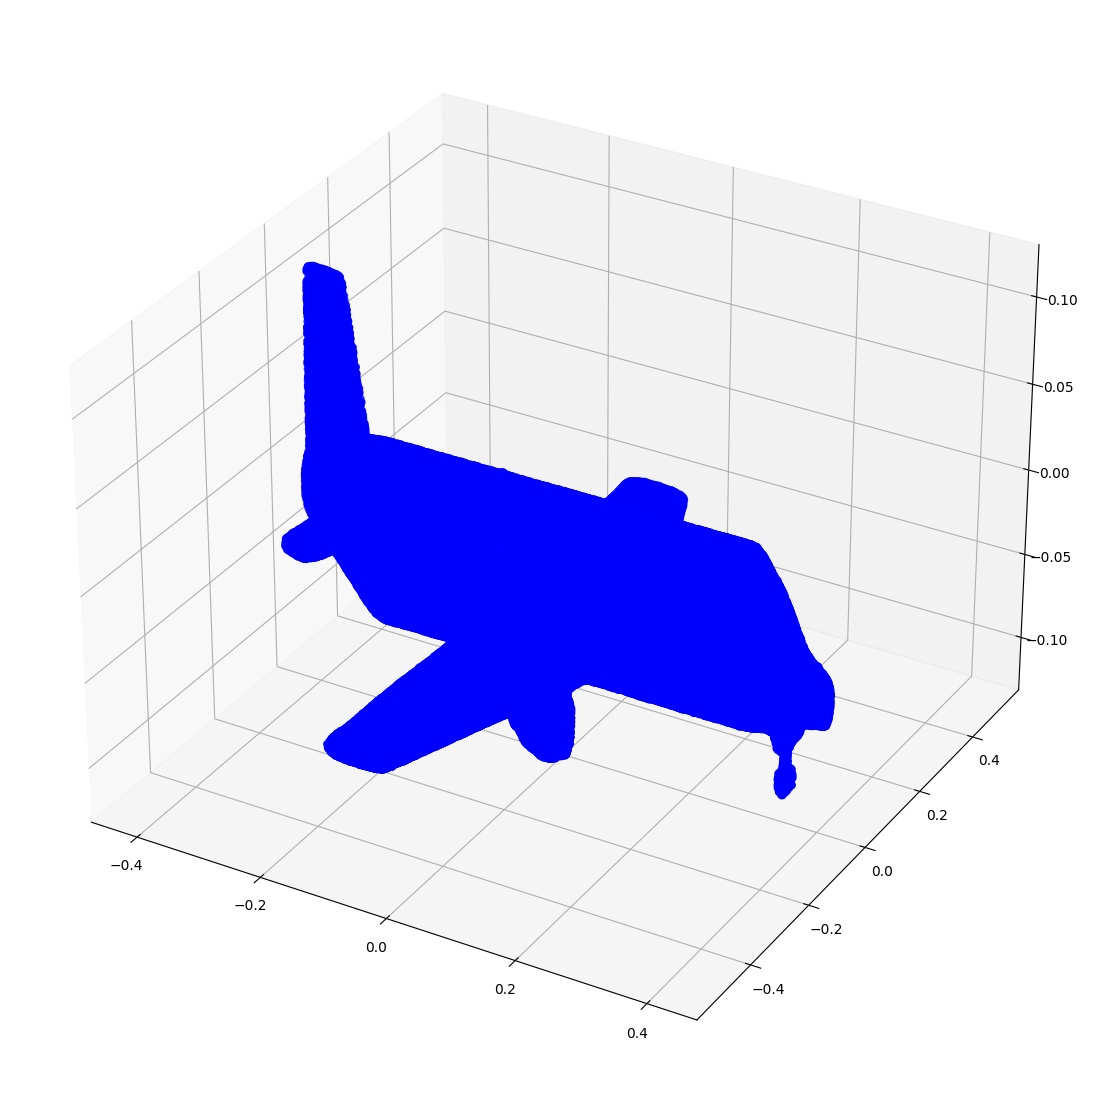

In [4]:
# Rotation
r = R.from_euler('xyz', (90, 0, 0), degrees=True)
spn_points = r.apply(spn_points)
plot_3d_points(spn_points)

In [5]:
r, lat, lon = ac.cartesian_to_spherical(spn_points[:, 0], spn_points[:, 1], spn_points[:, 2])

# resolution: 0.01 * 0.01
resolution = 0.0001

num_lat = np.array((np.ceil((lat.max() - lat.min()) / resolution)), dtype=int).item()
num_lon = np.array((np.ceil((lon.max() - lon.min()) / resolution)), dtype=int).item()

# grid = ([[[]] * num_lon] * num_lat)
grid = np.zeros([num_lat, num_lon], dtype=int) - 1
r_grid = copy.deepcopy(grid)

lat_ths = np.arange(np.array(lat.min()).item(), np.array(lat.max()).item() + resolution, resolution)
lon_ths = np.arange(np.array(lon.min()).item(), np.array(lon.max()).item() + resolution, resolution)

for point_index in range(lat.shape[0]):
    current_lat = lat[point_index]
    current_lon = lon[point_index]
    current_r = r[point_index]

    grid_lat = int((np.array(current_lat).item() - np.array(lat.min()).item()) / resolution)
    grid_lon = int((np.array(current_lon).item() - np.array(lon.min()).item()) / resolution)
    # if previously no point for current location,
    # fill in current poitn index and current r for current locaiton
    if grid[grid_lat][grid_lon] == -1:
        grid[grid_lat][grid_lon] = point_index
        r_grid[grid_lat][grid_lon] = current_r
    else:
        old_r = r_grid[grid_lat][grid_lon]
        if current_r < old_r:
            # replace r and point_index at current location
            grid[grid_lat][grid_lon] = point_index
            r_grid[grid_lat][grid_lon] = current_r

remaining_indices = []
for row_index in range(grid.shape[0]):
    for col_index in range(grid.shape[1]):
        current_point_index = grid[row_index][col_index]
        if current_point_index > -1:
            remaining_indices.append(current_point_index)

remaining_r = r[remaining_indices]
remaining_lat = lat[remaining_indices]
remaining_lon = lon[remaining_indices]

remaining_x, remaining_y, remaining_z = ac.spherical_to_cartesian(remaining_r, remaining_lat, remaining_lon)

kept_spn_points = torch.tensor(
    np.vstack([np.array(remaining_x), np.array(remaining_y), np.array(remaining_z)])).permute(1, 0).numpy()

spn_points = kept_spn_points

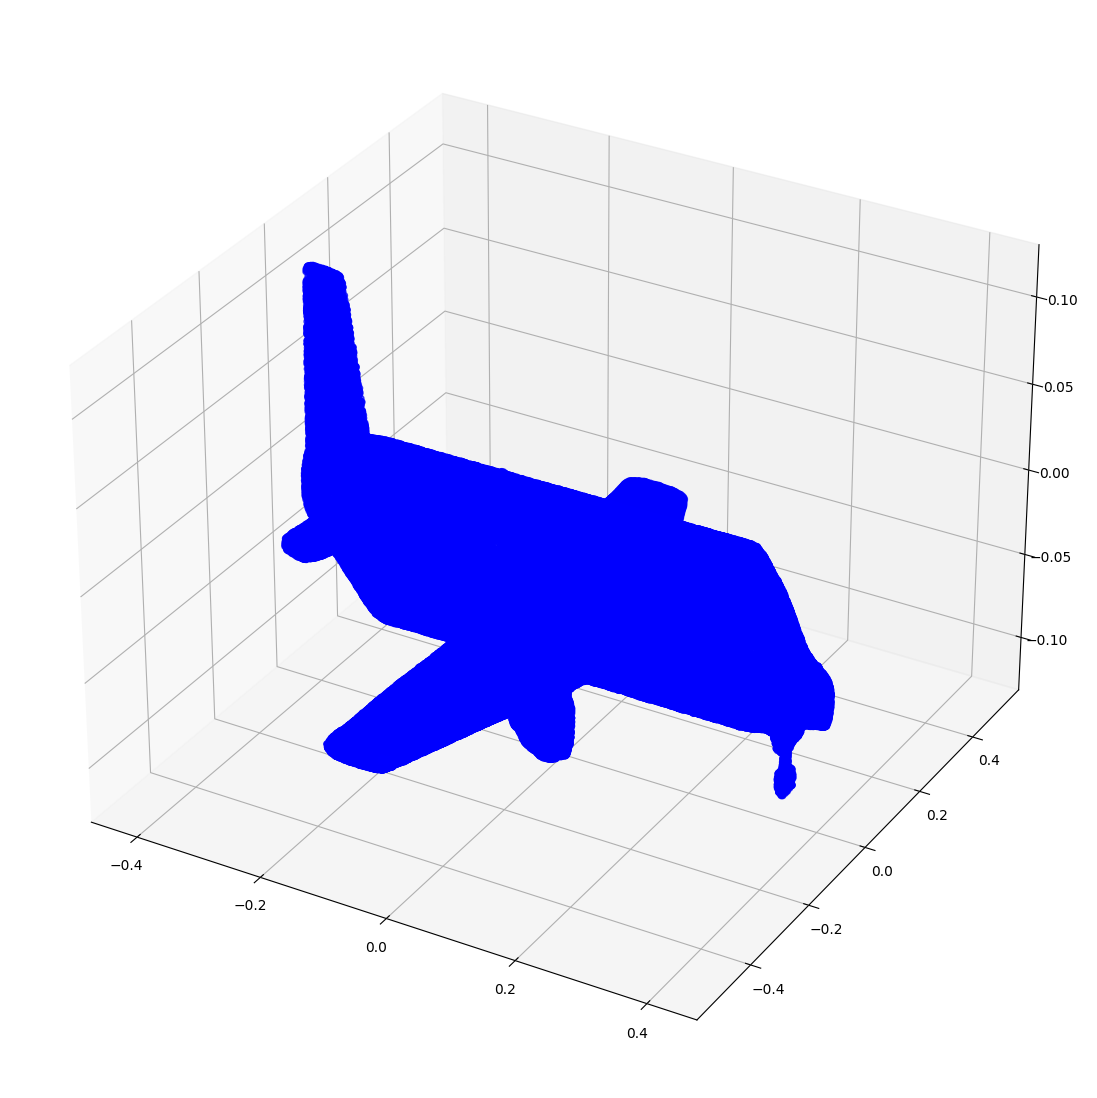

In [6]:
plot_3d_points(spn_points)